In [ ]:
#-----GRAPH CLASSIFICATION-----#

In [1]:
import hipopy.hipopy as hp
import os
import pandas as pd
import os
import numpy as np
import numpy.ma as ma
import awkward as ak
from tqdm import tqdm
import torch
import torch_geometric as tg
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset, download_url
import torch_geometric.transforms as T

#NOTE: NEW 2/20/23
from typing import List, Union

from torch_geometric.data import Data, HeteroData
from torch_geometric.data.datapipes import functional_transform
from torch_geometric.transforms import BaseTransform

import modeloss

import itertools #NOTE: FOR DA TRAINING?  BUT IF YOU TRAIN DISCRIMINATOR FIRST YOU WON'T NEED THIS

#TODO: DEFINE TRANSFORMS
import torch_geometric.transforms as T

import matplotlib.pyplot as plt
# transform=T.KNNGraph(k=2) #NOTE: GRAPH.pos needs to be defined to use this
# transform=T.NormalizeFeatures()
# transform=T.Compose([T.KNNGraph(k=3,loop=False)])
# transform = T.Compose([T.KNNGraph(k=10,loop=True),NormalizeFeaturesNewTest(),T.ToUndirected(),T.AddSelfLoops()]) #T.AddSelfLoops(),
transform=None #NOTE: FOR SOME REASON T.ToUndirected() is changing the length of the graph labels??!?!?!?!?!?!RRRRRRG FRUSTRATING.
transform=T.NormalizeFeatures()

# Class definitions
class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])
        # For PyG<2.4:
        # self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        # Read data into huge `Data` list.
        data_list = None

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])
        # For PyG<2.4:
        # torch.save(self.collate(data_list), self.processed_paths[0])

# Function definitions
def get_dataset(root='/work/clas12/users/mfmce/pyg_test_rec_particle_dataset_3_7_25/'):
    dataset = MyOwnDataset(
                root,
                transform=None, #T.Compose([T.ToUndirected(),T.KNNGraph(k=6)]),
                pre_transform=None,
                pre_filter=None
            )

    return dataset

    data = dataset[0]
    print('DEBUGGING: len(dataset)  = ',len(dataset))
    print('DEBUGGING: len(dataset.data)  = ',len(dataset.data))
    print('DEBUGGING: len(dataset.y)  = ',len(dataset.y))
    print('DEBUGGING: dataset.y.shape = ',dataset.y.shape)

    print(data.x.shape)
    print(data.x)
    # print(data.x[0])
    # print(data.x[0].sum())
    print(data.y.shape)
    print(data.y)
    print("DEBUGGING: data.x.dtype = ",data.x.dtype)
    print("DEBUGGING: data.y.dtype = ",data.y.dtype)
    print("DEBUGGING: data.kinematics.dtype = ",data.kinematics.dtype)
    print("DEBUGGING: data.y.shape = ",data.y.shape)
    print("DEBUGGING: data.y = ",data.y)
    g = tg.utils.to_networkx(data,to_undirected=True)
    import networkx as nx
    node_labels = {i:int(val.item()*100) for i, val in enumerate(data.x[:,0])}
    nx.draw(g,labels=node_labels)
    print("Going through dataset")
    for idx, d in enumerate(dataset):
        if d.y.shape[0]>2:
            print("d.y = ",d.y)
            print("idx = ",idx)
        if torch.any(torch.isnan(d.x)):
            print("DEBUGGING: nan @ idx, d = ",idx,d)
        if torch.any(torch.isinf(d.x)):
            print("DEBUGGING: nan @ idx, d = ",idx,d)
            
    print("DONE")

    l_sig = []
    l_bg = []
    print("DEBUGGING: dataset[0].y[0].item()== 0 = ",dataset[0].y[0].item()==0)
    for data in dataset:
    #     if len(data.y)!=2: print("DEBUGGING: len(data.y) = ",len(data.y))
        if data.y[0].item()==1:
            l_sig.append(data)
        else:
            l_bg.append(data)
    b_sig = torch_geometric.data.Batch().from_data_list(l_sig)
    b_bg = torch_geometric.data.Batch().from_data_list(l_bg)
    print(b_sig.x.shape)
    print(b_sig.y.shape)
    print(b_bg.x.shape)
    print(b_bg.y.shape)

    def plot_data_separated(array_sig,array_bg,title=None,xlabel='index',nbins=100,low=-1.1,high=1.1):
        
        array_sig = array_sig.flatten()
        array_bg = array_bg.flatten()

        # Plot MC-Matched distributions
        f = plt.figure()
        if title != None:
            plt.title(title)
        plt.title('MC Distribution')
        plt.hist(array_sig, color='r', alpha=0.5, range=(low,high), bins=nbins, histtype='stepfilled', density=False, label='signal')
        plt.hist(array_bg, color='b', alpha=0.5, range=(low,high), bins=nbins, histtype='stepfilled', density=False, label='background')
        plt.legend(loc='upper left', frameon=False)
        plt.ylabel('Counts')
        plt.xlabel(xlabel)
    #     f.savefig(xlabel+'_separated_'+todays_date+'.png')
        plt.show()
        f.savefig(xlabel+os.path.basename(root)+'.pdf')
        
    arr1 = b_sig.kinematics
    arr2 = b_bg.kinematics

    print("DEBUGGING: b_sig.y.shape = ",b_sig.y.shape)
    print("DEBUGGING; b_bg.y.shape = ",b_bg.y.shape)
        
    # arr1 = []
    # for el in b_sig.kinematics:
    #     arr1.extend(el)
    # arr2 = []
    # for el in b_bg.kinematics:
    #     arr2.extend(el)

    arr1 = np.array(arr1)
    arr2 = np.array(arr2)

    print("DEBUGGING: type(arr1) = ",type(arr1))
    print("DEBUGGING: arr1.shape = ",arr1.shape)
    print("DEBUGGING: arr2.shape = ",arr2.shape)

    print("DEBUGGING: b_sig.x.dtype = ",b_sig.x.dtype)
    print("DEBUGGING: b_bg.x.dtype  = ",b_bg.x.dtype)

    print("DEBUGGING: b_sig.kinematics[0].dtype = ",b_sig.kinematics[0].dtype)
        
    # Plot data separated distributions
    plot_data_separated(arr1[:,3],arr2[:,3],xlabel="Q2",low=0.0,high=10.0)
    plot_data_separated(arr1[:,5],arr2[:,5],xlabel="W",low=0.0,high=5.0)
    plot_data_separated(arr1[:,6],arr2[:,6],xlabel="x",low=0.0,high=1.0)
    plot_data_separated(arr1[:,7],arr2[:,7],xlabel="y",low=0.0,high=1.0)
    plot_data_separated(arr1[:,8],arr2[:,8],xlabel="z",low=0.0,high=1.0)
    plot_data_separated(arr1[:,9],arr2[:,9],xlabel="xF",low=0.0,high=1.0)
    plot_data_separated(arr1[:,10],arr2[:,10],xlabel="mass",low=1.08,high=1.24)
    # plot_data_separated(arr1[:,4],arr2[:,4],xlabel="chi2")
    # plot_data_separated(arr1[:,5],arr2[:,5],xlabel="pid")
    # plot_data_separated(arr1[:,6],arr2[:,6],xlabel="status")

    return dataset

def get_dataset_dt(root='/work/clas12/users/mfmce/pyg_DATA_rec_particle_dataset_3_7_25/'):
    dataset = MyOwnDataset(
                root,
                transform=None, #T.Compose([T.ToUndirected(),T.KNNGraph(k=6)]),
                pre_transform=None,
                pre_filter=None
            )

    return dataset

    # DEBUGGING=True
    # if DEBUGGING:
    #     from torch_geometric.datasets import TUDataset
    #     dataset = TUDataset(root='/home/mfmce/drop', name='MUTAG')
    # print("DEBUGGING: len(dataset) = ",len(dataset))
    data = dataset[0]
    print('DEBUGGING: len(dataset)  = ',len(dataset))
    print('DEBUGGING: len(dataset.data)  = ',len(dataset.data))
    # print('DEBUGGING: len(dataset.isdata)  = ',len(dataset.isdata))
    # print('DEBUGGING: dataset.isdata.shape = ',dataset.isdata.shape)
    # # print(data.x)
    # # print(dataset)
    # # if transform is not None: print(transform(dataset[0]).edge_index)
    # # if transform is not None: print(transform(dataset[0]).x)
    print(data.x.shape)
    print(data.x)
    # # print(data.x[0])
    # # print(data.x[0].sum())
    # print(data.isdata.shape)
    # print(data.isdata)
    print("DEBUGGING: data.x.dtype = ",data.x.dtype)
    # print("DEBUGGING: data.isdata.dtype = ",data.isdata.dtype)
    print("DEBUGGING: data.kinematics.dtype = ",data.kinematics.dtype)
    # print("DEBUGGING: data.isdata.shape = ",data.isdata.shape)
    # print("DEBUGGING: data.isdata = ",data.isdata)
    g = tg.utils.to_networkx(data,to_undirected=True)
    import networkx as nx
    node_labels = {i:int(val.item()*100) for i, val in enumerate(data.x[:,0])}
    nx.draw(g,labels=node_labels)
    print("Going through dataset")
    # for idx, d in enumerate(dataset):
    #     if d.isdata.shape[0]>2:
    #         print("d.isdata = ",d.isdata)
    #         print("idx = ",idx)
    #     if torch.any(torch.isnan(d.x)):
    #         print("DEBUGGING: nan @ idx, d = ",idx,d)
    #     if torch.any(torch.isinf(d.x)):
    #         print("DEBUGGING: nan @ idx, d = ",idx,d)
            
    print("DONE")

    l_sig = []
    # l_bg = []
    # print("DEBUGGING: dataset[0].isdata[0].item()== 0 = ",dataset[0].isdata[0].item()==0)
    for data in dataset:
    #     if len(data.isdata)!=2: print("DEBUGGING: len(data.isdata) = ",len(data.isdata))
            # if data.isdata[0].item()==1:
        l_sig.append(data)
            # else:
                # l_bg.append(data)
    b_sig = torch_geometric.data.Batch().from_data_list(l_sig)
    # b_bg = torch_geometric.data.Batch().from_data_list(l_bg)
    print(b_sig.x.shape)
    # print(b_sig.isdata.shape)
    # # print(b_bg.x.shape)
    # # print(b_bg.isdata.shape)

    def plot_data_separated(array_sig,title=None,xlabel='index',nbins=100,low=-1.1,high=1.1):
        
        array_sig = array_sig.flatten()

        # Plot MC-Matched distributions
        f = plt.figure()
        if title != None:
            plt.title(title)
        plt.title('Data Distribution')
        plt.hist(array_sig, color='r', alpha=0.5, range=(low,high), bins=nbins, histtype='stepfilled', density=False, label='Data')
        # plt.hist(array_bg, color='b', alpha=0.5, range=(low,high), bins=nbins, histtype='stepfilled', density=False, label='background')
        plt.legend(loc='upper left', frameon=False)
        plt.ylabel('Counts')
        plt.xlabel(xlabel)
    #     f.savefig(xlabel+'_separated_'+todays_date+'.png')
        plt.show()
        f.savefig(xlabel+os.path.basename(root)+'.pdf')
        
    arr1 = b_sig.kinematics
    # arr2 = b_bg.kinematics

    # print("DEBUGGING: b_sig.isdata.shape = ",b_sig.isdata.shape)
    # # print("DEBUGGING; b_bg.isdata.shape = ",b_bg.isdata.shape)
        
    # arr1 = []
    # for el in b_sig.kinematics:
    #     arr1.extend(el)
    # arr2 = []
    # for el in b_bg.kinematics:
    #     arr2.extend(el)

    arr1 = np.array(arr1)
    # arr2 = np.array(arr2)

    print("DEBUGGING: type(arr1) = ",type(arr1))
    print("DEBUGGING: arr1.shape = ",arr1.shape)
    # print("DEBUGGING: arr2.shape = ",arr2.shape)

    print("DEBUGGING: b_sig.x.dtype = ",b_sig.x.dtype)
    # print("DEBUGGING: b_bg.x.dtype  = ",b_bg.x.dtype)

    print("DEBUGGING: b_sig.kinematics[0].dtype = ",b_sig.kinematics[0].dtype)
        
    # Plot data separated distributions
    plot_data_separated(arr1[:,3],xlabel="Q2",low=0.0,high=10.0)
    plot_data_separated(arr1[:,5],xlabel="W",low=0.0,high=5.0)
    plot_data_separated(arr1[:,6],xlabel="x",low=0.0,high=1.0)
    plot_data_separated(arr1[:,7],xlabel="y",low=0.0,high=1.0)
    plot_data_separated(arr1[:,8],xlabel="z",low=0.0,high=1.0)
    plot_data_separated(arr1[:,9],xlabel="xF",low=0.0,high=1.0)
    plot_data_separated(arr1[:,10],xlabel="mass",low=1.08,high=1.24)
    # plot_data_separated(arr1[:,4],arr2[:,4],xlabel="chi2")
    # plot_data_separated(arr1[:,5],arr2[:,5],xlabel="pid")
    # plot_data_separated(arr1[:,6],arr2[:,6],xlabel="status")

    return dataset

# Load full PROTEINS dataset
DATASET_NAME = 'LAMBDAS'
full_ds, src_ds, tgt_ds = None, None, None
if DATASET_NAME == 'PROTEINS':
    full_ds = TUDataset(root='/home/mfmce/drop/data/'+DATASET_NAME, name=DATASET_NAME)
    
    # Shuffle and split into two subsets
    total_len = len(full_ds)
    split_len = total_len // 2
    src_ds, tgt_ds = random_split(full_ds, [split_len, total_len - split_len])

if DATASET_NAME == 'LAMBDAS':
    max_idx = 1000
    
    src_ds = get_dataset(root='/work/clas12/users/mfmce/pyg_test_rec_particle_dataset_3_7_25/')[0:max_idx]
    
    tgt_ds = get_dataset_dt(root='/work/clas12/users/mfmce/pyg_DATA_rec_particle_dataset_3_5_24/')[0:max_idx]

#dataset_both = TODO: SEE BELOW

Epoch 001 total_loss: 22.7534 loss_cls: 21.2417 loss_mmd: 7.3735 loss_auc: 61.6446 loss_soft: 3.3599
Epoch 002 total_loss: 23.6490 loss_cls: 20.2791 loss_mmd: 6.7574 loss_auc: 60.2042 loss_soft: 10.6664
Epoch 003 total_loss: 22.8376 loss_cls: 20.8904 loss_mmd: 6.6697 loss_auc: 60.8606 loss_soft: 4.7554
Epoch 004 total_loss: 22.9340 loss_cls: 20.1579 loss_mmd: 6.2055 loss_auc: 59.7757 loss_soft: 7.9713
Epoch 005 total_loss: 22.3597 loss_cls: 19.5885 loss_mmd: 5.4564 loss_auc: 59.1663 loss_soft: 7.9040
Epoch 006 total_loss: 23.7334 loss_cls: 19.6737 loss_mmd: 4.9496 loss_auc: 59.2205 loss_soft: 12.9858
Epoch 007 total_loss: 23.5431 loss_cls: 19.8084 loss_mmd: 5.1182 loss_auc: 59.4400 loss_soft: 11.4972
Epoch 008 total_loss: 23.6102 loss_cls: 18.9714 loss_mmd: 5.0980 loss_auc: 58.2973 loss_soft: 15.0157
Epoch 009 total_loss: 23.2542 loss_cls: 19.4731 loss_mmd: 5.0268 loss_auc: 58.7892 loss_soft: 11.4380
Epoch 010 total_loss: 23.3030 loss_cls: 19.6095 loss_mmd: 4.8688 loss_auc: 58.9444 los

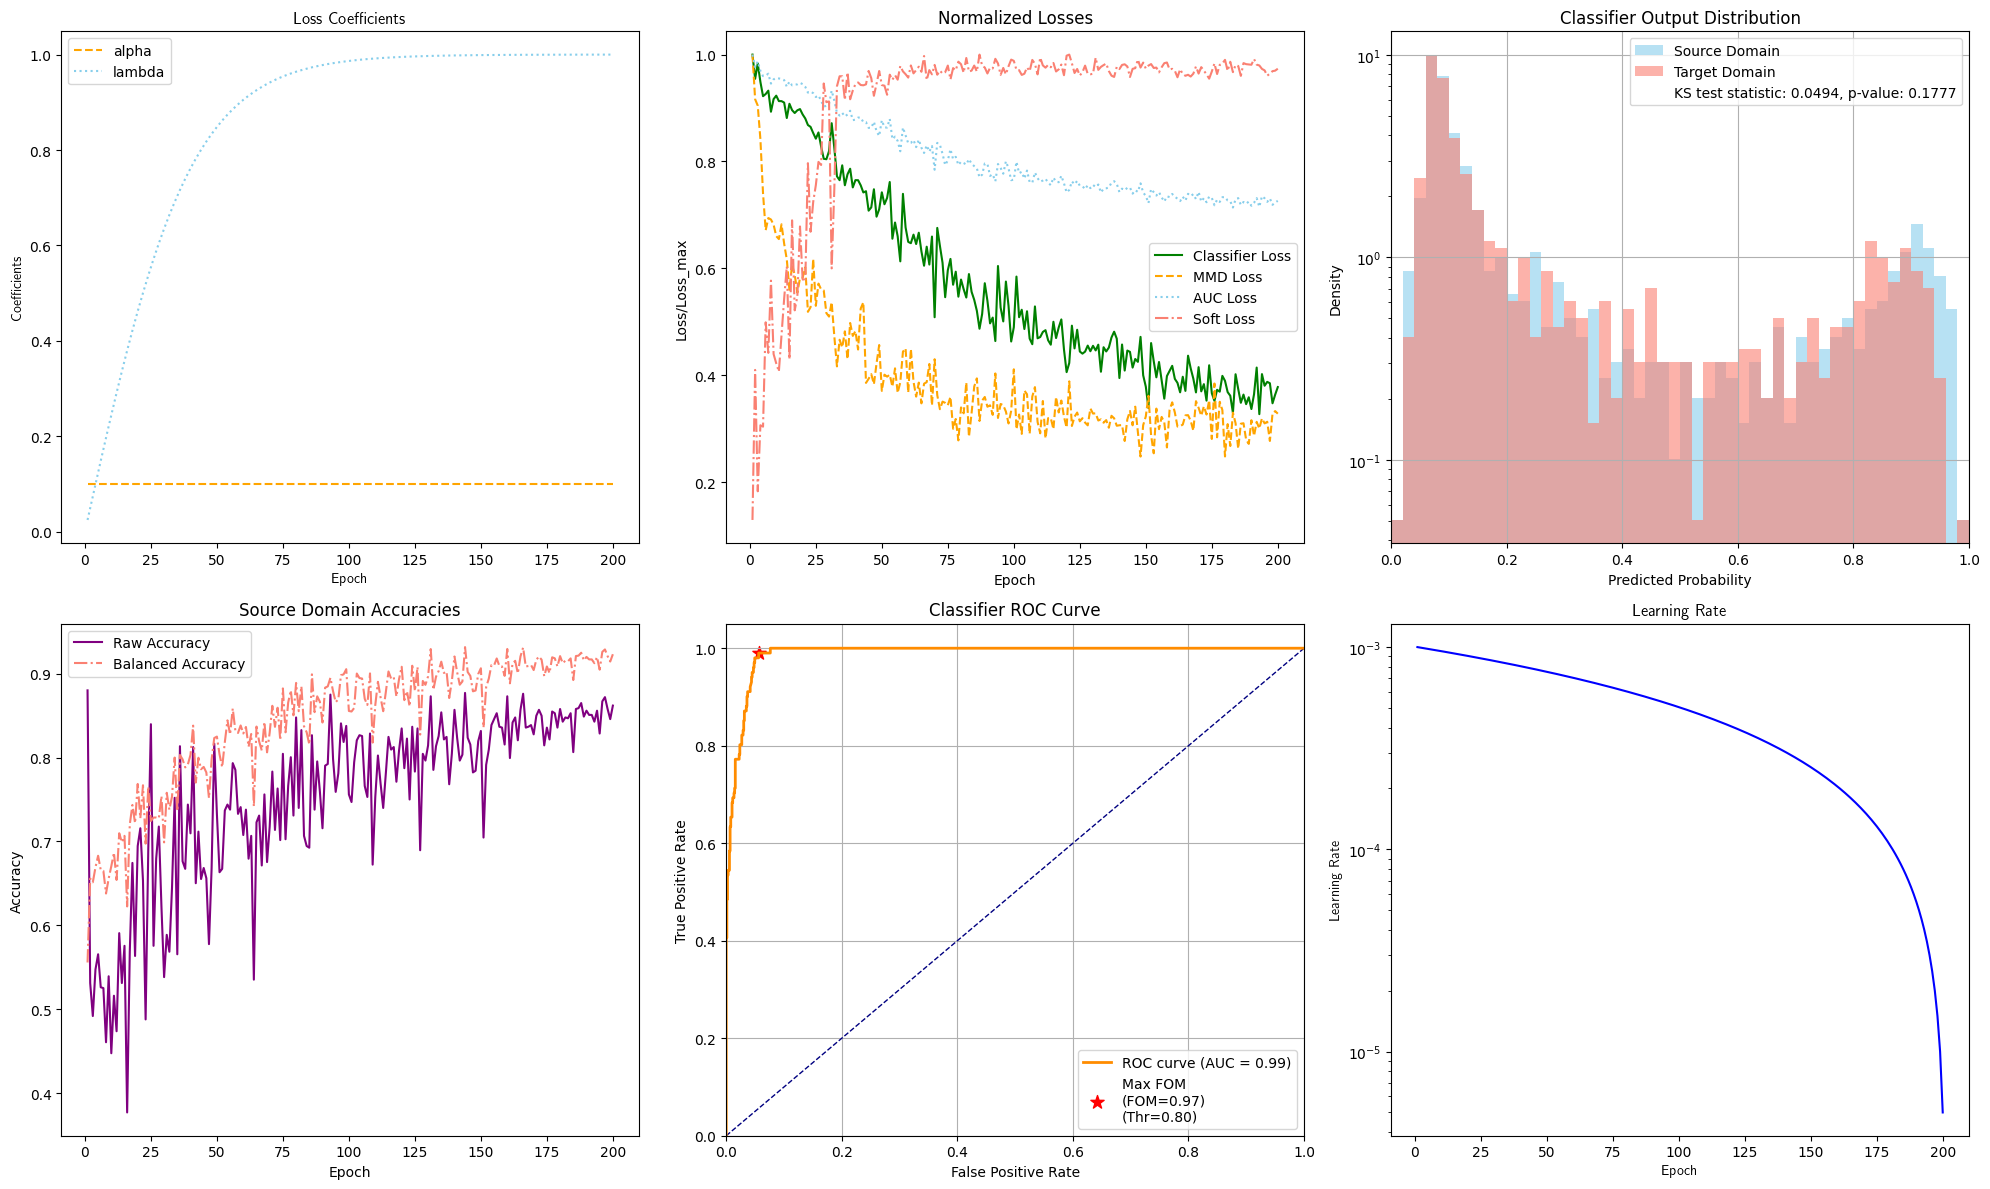

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    GCNConv,
    SAGEConv,
    GATConv,
    GINConv,
    global_mean_pool,
)
from torch.optim.lr_scheduler import StepLR, LambdaLR
from torch.utils.data import random_split, WeightedRandomSampler
import numpy as np
from sklearn.metrics import roc_curve, auc
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.autograd import Variable
import math

# Gradient Reversal Layer
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.alpha * grad_output, None

# # GNN Encoder for graphs
# class GNNEncoder(nn.Module):
#     def __init__(self, in_dim, hidden_dim):
#         super().__init__()
#         self.conv1 = GCNConv(in_dim, hidden_dim)
#         self.conv2 = GCNConv(hidden_dim, hidden_dim)

#     def forward(self, x, edge_index, batch):
#         x = F.relu(self.conv1(x, edge_index))
#         x = self.conv2(x, edge_index)
#         return global_mean_pool(x, batch)  # graph-level representation

class FlexibleGNNEncoder(nn.Module):
    def __init__(
        self,
        in_dim,
        hidden_dim,
        num_layers=2,
        gnn_type='gcn',        # Options: 'gcn', 'sage', 'gat', 'gin'
        dropout=0.5,
        heads=1                # For GAT
    ):
        super().__init__()

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.dropout = dropout
        self.gnn_type = gnn_type.lower()

        # First layer
        self.convs.append(self._build_conv(self.gnn_type, in_dim, hidden_dim, heads))
        self.bns.append(nn.BatchNorm1d(hidden_dim * (heads if self.gnn_type == 'gat' else 1)))

        # Hidden layers
        for _ in range(num_layers - 1):
            in_ch = hidden_dim * (heads if self.gnn_type == 'gat' else 1)
            out_ch = hidden_dim
            self.convs.append(self._build_conv(self.gnn_type, in_ch, out_ch, heads))
            self.bns.append(nn.BatchNorm1d(out_ch * (heads if self.gnn_type == 'gat' else 1)))

    def _build_conv(self, gnn_type, in_dim, out_dim, heads):
        if gnn_type == 'gcn':
            return GCNConv(in_dim, out_dim)
        elif gnn_type == 'sage':
            return SAGEConv(in_dim, out_dim)
        elif gnn_type == 'gat':
            return GATConv(in_dim, out_dim, heads=heads, concat=True)
        elif gnn_type == 'gin':
            return GINConv(
                nn.Sequential(
                    nn.Linear(in_dim, out_dim),
                    nn.ReLU(),
                    nn.Linear(out_dim, out_dim)
                )
            )
        else:
            raise ValueError(f"Unsupported GNN type: {gnn_type}")

    def forward(self, x, edge_index, batch):
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        return global_mean_pool(x, batch)

# # Graph Classifier Head
# class GraphClassifier(nn.Module):
#     def __init__(self, hidden_dim, num_classes):
#         super().__init__()
#         self.fc = nn.Linear(hidden_dim, num_classes)

#     def forward(self, graph_emb):
#         return self.fc(graph_emb)

class GraphClassifier(nn.Module):
    def __init__(self, in_dim, out_dim, num_layers=2, hidden_dim=64, dropout=0.5):
        super().__init__()
        self.layers = nn.ModuleList()
        self.dropout = dropout

        # Input layer
        if num_layers == 1:
            self.layers.append(nn.Linear(in_dim, out_dim))
        else:
            self.layers.append(nn.Linear(in_dim, hidden_dim))
            for _ in range(num_layers - 2):
                self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.Linear(hidden_dim, out_dim))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x


# # Domain Discriminator Head
# class DomainDiscriminator(nn.Module):
#     def __init__(self, hidden_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(hidden_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, 2)  # domain: source=0, target=1

#     def forward(self, graph_emb, alpha):
#         x = GradReverse.apply(graph_emb, alpha)
#         x = F.relu(self.fc1(x))
#         return self.fc2(x)

class DomainDiscriminator(nn.Module):
    def __init__(self, in_dim, num_layers=2, hidden_dim=64, dropout=0.5):
        super().__init__()
        self.layers = nn.ModuleList()
        self.dropout = dropout

        if num_layers == 1:
            self.layers.append(nn.Linear(in_dim, 2))
        else:
            self.layers.append(nn.Linear(in_dim, hidden_dim))
            for _ in range(num_layers - 2):
                self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.Linear(hidden_dim, 2))  # binary domain classification

    def forward(self, x, alpha=1.0):
        # x = GradReverse.apply(x, alpha)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x

# Projection head for contrastive loss
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, proj_dim):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(in_dim, proj_dim),
            nn.ReLU(),
            nn.Linear(proj_dim, proj_dim)
        )

    def forward(self, x):
        return self.proj(x)

# Contrastive loss: NT-Xent (simplified)
def contrastive_loss(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    batch_size = z1.size(0)

    representations = torch.cat([z1, z2], dim=0)
    similarity = torch.matmul(representations, representations.T)

    sim_ij = torch.diag(similarity, batch_size)
    sim_ji = torch.diag(similarity, -batch_size)
    positives = torch.cat([sim_ij, sim_ji], dim=0)

    nominator = torch.exp(positives / temperature)
    denominator = torch.sum(torch.exp(similarity / temperature), dim=1) - torch.exp(torch.ones_like(positives) / temperature)
    loss = -torch.log(nominator / denominator)
    return loss.mean()


# Load datasets (example: MUTAG → PROTEINS)
# src_ds = TUDataset(root='/home/mfmce/drop/data/ENZYMES', name='ENZYMES')
# tgt_ds = TUDataset(root='/home/mfmce/drop/data/PROTEINS', name='PROTEINS')

# src_loader = DataLoader(src_ds, batch_size=32, shuffle=True)
# tgt_loader = DataLoader(tgt_ds, batch_size=32, shuffle=True)



#----- Create weighted data loader for source data -----#

# Count class distribution
labels = torch.tensor([data.y.item() for data in src_ds])
class_counts = torch.bincount(labels)
class_weights = 1. / class_counts.float()
sample_weights = [class_weights[label] for label in labels]
# print("DEBUGGING: class_counts   = ",class_counts)
# print("DEBUGGING: class_weights  = ",class_weights)
# print("DEBUGGING: sample_weights = ",sample_weights)

sampler = WeightedRandomSampler(weights=sample_weights,
                                 num_samples=len(src_ds),
                                 replacement=True)

src_loader = DataLoader(src_ds, batch_size=32, sampler=sampler, drop_last=True)

#--------------------------------------------------------#

# Create DataLoaders
src_loader_unweighted = DataLoader(src_ds, batch_size=32, shuffle=True, drop_last=True)
tgt_loader = DataLoader(tgt_ds, batch_size=32, shuffle=True, drop_last=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 200
num_classes = 2
gnn_type = "gin"
hdim_gnn = 64
num_layers_gnn = 3
num_layers_clf = 3
hdim_clf = 128
num_node_features = src_ds.num_node_features if DATASET_NAME=="LAMBDAS" else full_ds.num_node_features

heads = 4
encoder = FlexibleGNNEncoder(
    in_dim=num_node_features,
    hidden_dim=hdim_gnn,
    num_layers=num_layers_gnn,
    gnn_type=gnn_type,      # Try 'gcn', 'sage', 'gat', 'gin'
    dropout=0.4,
    heads=heads              # Only relevant for GAT
).to(device)

projector = ProjectionHead(64 * (heads if gnn_type=="gat" else 1), 32).to(device)

clf = GraphClassifier(
    in_dim=hdim_gnn * (heads if gnn_type=="gat" else 1),
    out_dim=num_classes,
    num_layers=num_layers_clf,
    hidden_dim=hdim_clf,
    dropout=0.4
).to(device)

disc = DomainDiscriminator(
    in_dim=64 * (heads if gnn_type=="gat" else 1),
    num_layers=4,
    hidden_dim=128,
    dropout=0.4
).to(device)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(clf.parameters()) + list(disc.parameters()),
    lr=0.001
)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# Linear decay from 1.0 to 0.0 over epochs
lr_lambda = lambda epoch: (1 - (epoch / epochs))
scheduler = LambdaLR(optimizer, lr_lambda)

# # scheduler = None

def alpha_fn(epoch, total_epochs, coefficient = 0.05):
    # Default schedule: DANN-style ramp-up
    return coefficient * (2. / (1. + np.exp(-10 * epoch / total_epochs)) - 1)

alpha_fn = 0.1

# Annealed temperature
def temp_fn(epoch, max_epoch, t_min=0.07, t_max=0.5):
    return t_min + (t_max - t_min) * (1 - epoch / max_epoch)

temp_fn = 0.1


#----- TIToK Loss definitions -----#

def exploss(y_source_prob, y_source, alpha=0.5):
    loss_sum = 0
    nc = y_source_prob.size(1)
    for i in range(nc):
        index_i = y_source == i
        a = torch.exp(-alpha * y_source_prob[index_i, i])
        b = 0
        for j in range(nc):
            if j == i:
                continue
            index_j = y_source == j
            ni = index_i.float().sum().item()
            nj = index_j.float().sum().item()
            if ni > 0 and nj > 0:
                b += torch.sum(torch.exp(alpha * y_source_prob[index_j, i])) / (ni * nj)
        loss_sum += torch.sum(a) * b
    return loss_sum

def soft_label_loss(tar_logits, soft_labels_batch, temperature=2.0):
    loss_soft = torch.zeros(())
    output = F.softmax(tar_logits / temperature, dim=1)
    if float(output.size(0)) > 0:
        loss_soft = -torch.sum(soft_labels_batch * torch.log(output)) / output.size(0)
    return loss_soft

def gaussian_kernel(x, y, kernel_mul=2.0, kernel_num=5):
    total = torch.cat([x, y], dim=0)
    total0 = total.unsqueeze(0).expand(total.size(0), -1, -1)
    total1 = total.unsqueeze(1).expand(-1, total.size(0), -1)
    L2_distance = ((total0 - total1) ** 2).sum(2)
    
    bandwidth = torch.sum(L2_distance.data) / (total.size(0) ** 2 - total.size(0))
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul ** i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bw) for bw in bandwidth_list]
    return sum(kernel_val)

def mmd_loss(source, target):
    batch_size = source.size(0)
    kernels = gaussian_kernel(source, target)
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    loss = torch.mean(XX + YY - XY - YX)
    return loss

def eval_model(loader,num_classes=2,return_labels=False):
    encoder.eval()
    clf.eval()
    correct = total = 0
    logits = []
    labels = []
    correct_per_class = torch.zeros(num_classes).to(device)
    total_per_class = torch.zeros(num_classes).to(device)
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            emb = encoder(batch.x, batch.edge_index, batch.batch)
            out = clf(emb)
            pred = F.softmax(out,dim=1).argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
            if return_labels:
                logits.extend(F.softmax(out,dim=1)[:,1].cpu().tolist())
                labels.extend(batch.y.cpu().tolist())

            for i in range(len(pred)):
                label = batch.y[i]
                total_per_class[label] += 1
                if pred[i] == label:
                    correct_per_class[label] += 1

    # Avoid division by zero
    per_class_acc = correct_per_class / (total_per_class + 1e-8)

    # Compute average per-class accuracy
    valid_class_mask = total_per_class > 0
    balanced_acc = per_class_acc[valid_class_mask].mean().item()

    acc = correct / total
    
    return acc, per_class_acc.cpu().tolist(), balanced_acc, logits, labels

def lambda_fn(epoch, epochs):
    return 2 / (1 + math.exp(-10 * epoch / epochs)) - 1

#NOTE: FROM: https://github.com/big-chuan-bro/TiTok/blob/main/ImbalancedDA/Titok.py
def gen_soft_labels(num_classes, src_loader, encoder, clf, temperature=2):
    
    encoder.eval()
    clf.eval()
    cuda = torch.cuda.is_available()
    soft_labels = torch.zeros(num_classes, 1, num_classes).cuda()
    sum_classes = torch.zeros(num_classes).cuda()
    pred_scores_total = []
    label_total = []

    for src_batch in src_loader:

        src_batch  = src_batch.to(device)
        src_feats  = encoder(src_batch.x, src_batch.edge_index, src_batch.batch)
        src_logits = clf(src_feats)
        label_total.append(src_batch.y)

        pred_scores = F.softmax(src_logits / temperature, dim=1).data.cuda()
        pred_scores_total.append(pred_scores)

    pred_scores_total = torch.cat(pred_scores_total)
    label_total = torch.cat(label_total)

    for i in range(len(src_loader)):
        sum_classes[label_total[i]] += 1
        soft_labels[label_total[i]][0] += pred_scores_total[i]
    for cl_idx in range(num_classes):
        soft_labels[cl_idx][0] /= sum_classes[cl_idx]
    return soft_labels


# soft label for each batch #NOTE: FROM: https://github.com/big-chuan-bro/TiTok/blob/main/ImbalancedDA/Titok.py
def ret_soft_label(label, soft_labels, num_classes=2):
    
    soft_label_for_batch = torch.zeros(label.size(0), num_classes).to(device)
    for i in range(label.size(0)):
        # print("DEBUGGING: type(label) = ",type(label))
        # print("DEBUGGING: label.dtype = ",label.dtype)
        # print("DEBUGGING: label.shape = ",label.shape)
        # print("DEBUGGING: label.data[i] = ",label.data[i])
        soft_label_for_batch[i] = soft_labels[label.data[i]]

    return soft_label_for_batch

def train(encoder, clf, src_loader, tgt_loader, num_classes=2, soft_labels_temp=2, epochs=100, temp_fn=temp_fn, alpha_fn=alpha_fn, lambda_fn=lambda_fn):

    soft_labels = gen_soft_labels(num_classes, src_loader, encoder, clf, temperature=soft_labels_temp)
    
    encoder.train()
    clf.train()

    # Set logging lists to return
    total_losses       = []
    total_losses_cls   = []
    total_losses_auc   = []
    total_losses_mmd   = []
    total_losses_soft  = []
    src_accs           = []
    src_per_class_accs = []
    src_balanced_accs  = []
    lrs                = []

    # Loop training epochs
    for epoch in range(1, epochs+1):

        # Check alpha function
        if callable(alpha_fn):
            alpha = alpha_fn(epoch, epochs)
        else:
            alpha = alpha_fn

        # Check temp function
        if callable(temp_fn):
            temp = temp_fn(epoch, epochs)
        else:
            temp = temp_fn

        # Check lambda function
        if callable(lambda_fn):
            lambd = lambda_fn(epoch, epochs)
        else:
            lambd = lambda_fn
        
        total_loss      = 0
        total_loss_cls  = 0
        total_loss_auc  = 0
        total_loss_mmd  = 0
        total_loss_soft = 0
        # Parallel iteration over source and target loaders
        for src_batch, tgt_batch in zip(src_loader, tgt_loader):
            optimizer.zero_grad()

            # Source graph forward pass
            src_batch  = src_batch.to(device)
            src_feats  = encoder(src_batch.x, src_batch.edge_index, src_batch.batch)
            src_logits = clf(src_feats)
            src_labels = src_batch.y

            # Target graph forward pass
            tgt_batch  = tgt_batch.to(device)
            tgt_feats  = encoder(tgt_batch.x, tgt_batch.edge_index, tgt_batch.batch)
            tgt_logits = clf(tgt_feats)

            #----- BEGIN TIToK -----#

            # GET CONFIDENT LABELS ON TARGET DOMAIN

            # Apply softmax to get probabilities
            tgt_probs = F.softmax(tgt_logits, dim=1)

            # Get max class probabilities
            confidences, pred_classes = torch.max(tgt_probs, dim=1)  # [B]

            # Select samples with confidence above a threshold
            threshold = 0.8
            mask = confidences >= threshold

            # Select the logits and predicted labels of those confident samples
            tgt_logits_confident = tgt_logits[mask]           # [B_confident, num_classes]
            tgt_labels_confident = pred_classes[mask]         # [B_confident]

            # GET SOFT LABELS

            # print("DEBUGGING: tgt_logits_confident[0:10] = ",tgt_logits_confident[0:10])
            # print("DEBUGGING: soft_labels = ",soft_labels)

            soft_labels_batch = ret_soft_label(tgt_labels_confident, soft_labels, num_classes=num_classes)

            # LOSS COMPUTATIONS

            # Source classification
            loss_cls = F.cross_entropy(src_logits, src_labels)
            
            # AUC-style loss (exploss)
            loss_auc = exploss(F.softmax(src_logits, dim=1), src_labels, alpha=0.5)
            
            # Optional: MMD between source/target embeddings
            loss_mmd = mmd_loss(src_feats, tgt_feats)
            
            # Target knowledge distillation (on confident samples only)
            loss_soft = soft_label_loss(tgt_logits_confident, soft_labels_batch, temperature=2.0)
            
            # Combine
            loss = loss_cls + 0.3 * lambd * loss_mmd + 0.01 * loss_auc + 0.25 * loss_soft

            #------- END TIToK -----#
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_loss_cls += loss_cls.item()
            total_loss_mmd += loss_mmd.item()
            total_loss_auc += loss_auc.item()
            total_loss_soft += loss_soft.item()

        # Get accuracy
        src_acc, src_per_class_acc, src_balanced_acc, _, _ = eval_model(src_loader_unweighted)
        encoder.train()
        clf.train()

        # Append metrics for logging
        total_losses.append(total_loss)
        total_losses_cls.append(total_loss_cls)
        total_losses_mmd.append(total_loss_mmd)
        total_losses_auc.append(total_loss_auc)
        total_losses_soft.append(total_loss_soft)
        src_accs.append(src_acc)
        src_per_class_accs.append(src_per_class_acc)
        src_balanced_accs.append(src_balanced_acc)

        # Log and step learning rate scheduler
        lrs.append(optimizer.param_groups[0]['lr'])
        if scheduler is not None: scheduler.step()

        print(f'Epoch {epoch:03d} total_loss: {total_loss:.4f} loss_cls: {total_loss_cls:.4f} loss_mmd: {total_loss_mmd:.4f} loss_auc: {total_loss_auc:.4f} loss_soft: {total_loss_soft:.4f}')

    return total_losses, total_losses_cls, total_losses_mmd, total_losses_auc, total_losses_soft, src_accs, src_per_class_accs, src_balanced_accs, lrs

total_losses, total_losses_cls, total_losses_mmd, total_losses_auc, total_losses_soft, src_accs, src_per_class_accs, src_balanced_accs, lrs = train(encoder, clf, src_loader, tgt_loader, num_classes=2, soft_labels_temp=2, epochs=epochs, temp_fn=temp_fn, alpha_fn=alpha_fn, lambda_fn=lambda_fn)

src_acc, src_per_class_acc, src_balanced_acc, outs, ys = eval_model(src_loader_unweighted,return_labels=True)
tgt_acc, tgt_per_class_acc, tgt_balanced_acc, tgt_outs, _ = eval_model(tgt_loader,return_labels=True)
# dis_acc, dis_outs, _ = eval_disc(src_loader,tgt_loader,return_labels=True,alpha=1.0)
print(f'Source Accuracy: {src_acc:.4f}')
print(f'Source Per Class Accuracy: {src_per_class_acc}')
print(f'Source Balanced Accuracy: {src_balanced_acc:.4f}')
if DATASET_NAME!='LAMBDAS': print(f'Target Accuracy: {tgt_acc:.4f}')
# print(f'Discri Accuracy: {dis_acc:.4f}')

# Temperature values
epoch_range   = np.arange(1, epochs + 1)
alpha_values  = [alpha_fn(e, epochs) if callable(alpha_fn) else alpha_fn for e in epoch_range]
lambda_values = [lambda_fn(e, epochs) if callable(lambda_fn) else lambda_fn for e in epoch_range]

# Plot
fig, axs = plt.subplots(2, 3, figsize=(20, 12))

# Alpha
axs[0, 0].plot(epoch_range, alpha_values, color='orange', linestyle='--', label='alpha')
axs[0, 0].plot(epoch_range, lambda_values, color='skyblue', linestyle=':', label='lambda')
axs[0, 0].set_title('Loss Coefficients',usetex=True)
axs[0, 0].set_xlabel('Epoch',usetex=True)
axs[0, 0].set_ylabel('Coefficients',usetex=True)
axs[0, 0].legend(loc='best')

# Classifier & Domain Losses
axs[0, 1].plot(epoch_range, total_losses_cls/np.max(total_losses_cls), label='Classifier Loss', linestyle='-', color='green')
axs[0, 1].plot(epoch_range, total_losses_mmd/np.max(total_losses_mmd), label='MMD Loss', linestyle='--', color='orange')
axs[0, 1].plot(epoch_range, total_losses_auc/np.max(total_losses_auc), label='AUC Loss', linestyle=':', color='skyblue')
axs[0, 1].plot(epoch_range, total_losses_soft/np.max(total_losses_soft), label='Soft Loss', linestyle='-.', color='salmon')
axs[0, 1].set_title('Normalized Losses')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss/Loss_max')
axs[0, 1].legend(loc='best')

# Accuracies
axs[1, 0].plot(epoch_range, src_accs, label='Raw Accuracy', linestyle='-', color='purple')
# axs[1, 0].plot(epoch_range, src_per_class_accs[:,0], label=f'Class {0} Accuracy', linestyle='.', color='blue')
axs[1, 0].plot(epoch_range, src_balanced_accs, label='Balanced Accuracy', linestyle='-.', color='salmon')
# axs[1, 0].plot(epoch_range, tgt_acc, label='Target Accuracy', color='red')
axs[1, 0].set_title('Source Domain Accuracies')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(ys, outs)
roc_auc = auc(fpr, tpr)

# Compute Figure of Merit: FOM = TPR / sqrt(TPR + FPR)
fom = tpr / np.sqrt(tpr + fpr + 1e-8)  # small value to avoid division by zero
best_idx = np.argmax(fom)
best_fpr, best_tpr, best_fom, best_thr = fpr[best_idx], tpr[best_idx], fom[best_idx], thresholds[best_idx]

# Plot ROC
axs[1, 1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axs[1, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
axs[1, 1].scatter(best_fpr, best_tpr, color='red', marker='*', s=100, label=f'Max FOM \n(FOM={best_fom:.2f})\n(Thr={best_thr:.2f})')
axs[1, 1].set_xlim([0.0, 1.0])
axs[1, 1].set_ylim([0.0, 1.05])
axs[1, 1].set_xlabel('False Positive Rate')
axs[1, 1].set_ylabel('True Positive Rate')
axs[1, 1].set_title('Classifier ROC Curve')
axs[1, 1].legend(loc="lower right")
axs[1, 1].grid(True)

# Run KS test
stat, p_value = ks_2samp(outs, tgt_outs)
print(f"KS test statistic: {stat:.4f}, p-value: {p_value:.4g}")

# Plot model outputs
axs[0, 2].hist(outs, bins=50, range=(0,1), alpha=0.6, label="Source Domain", color='skyblue', density=True)
axs[0, 2].hist(tgt_outs, bins=50, range=(0,1), alpha=0.6, label="Target Domain", color='salmon', density=True)
axs[0, 2].plot([], [], ' ', label=f"KS test statistic: {stat:.4f}, p-value: {p_value:.4g}")
axs[0, 2].set_xlim([0.0, 1.0])
axs[0, 2].set_title("Classifier Output Distribution")
axs[0, 2].set_xlabel("Predicted Probability")
axs[0, 2].set_ylabel("Density")
axs[0, 2].set_yscale('log')
axs[0, 2].legend()
axs[0, 2].grid(True)

# Learning rates
axs[1, 2].plot(epoch_range, lrs, color='blue')
axs[1, 2].set_title('Learning Rate',usetex=True)
axs[1, 2].set_xlabel('Epoch',usetex=True)
axs[1, 2].set_ylabel('Learning Rate',usetex=True)
axs[1, 2].set_yscale('log')

# # Hide unused subplot
# axs[0,2].axis('off')
# axs[1,2].axis('off')

plt.tight_layout()
plt.show()

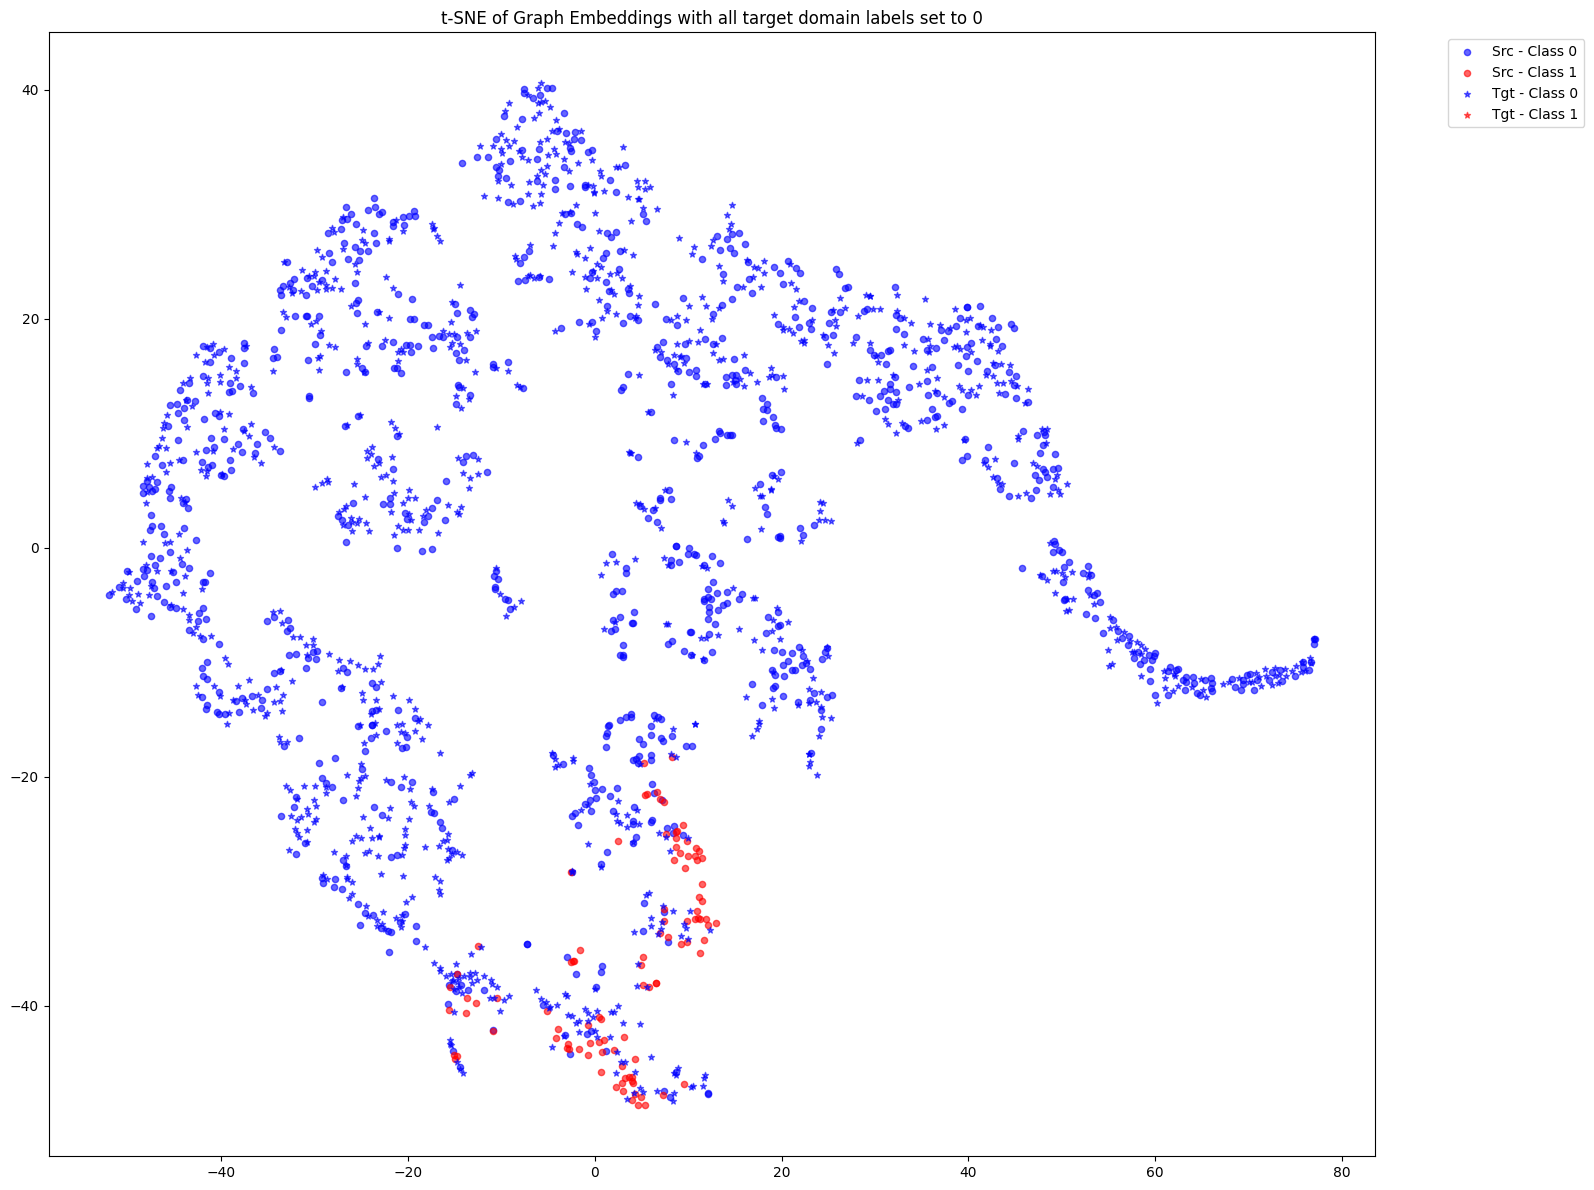

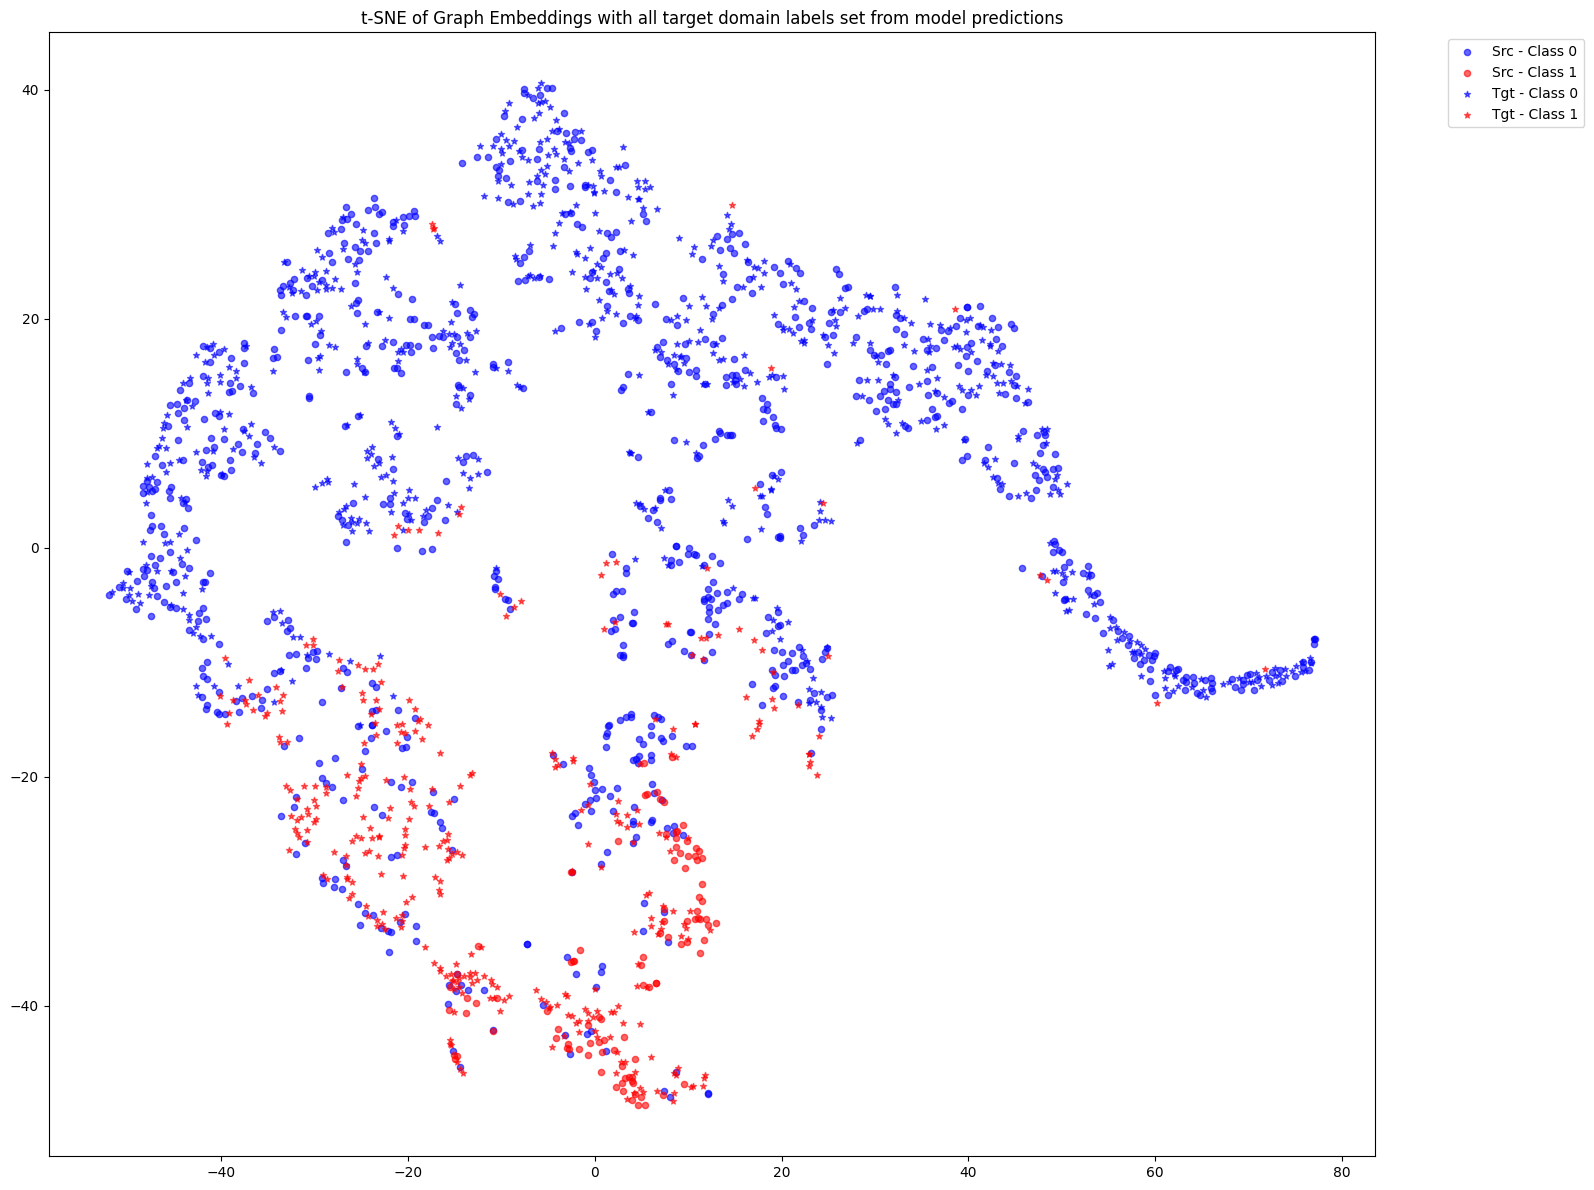

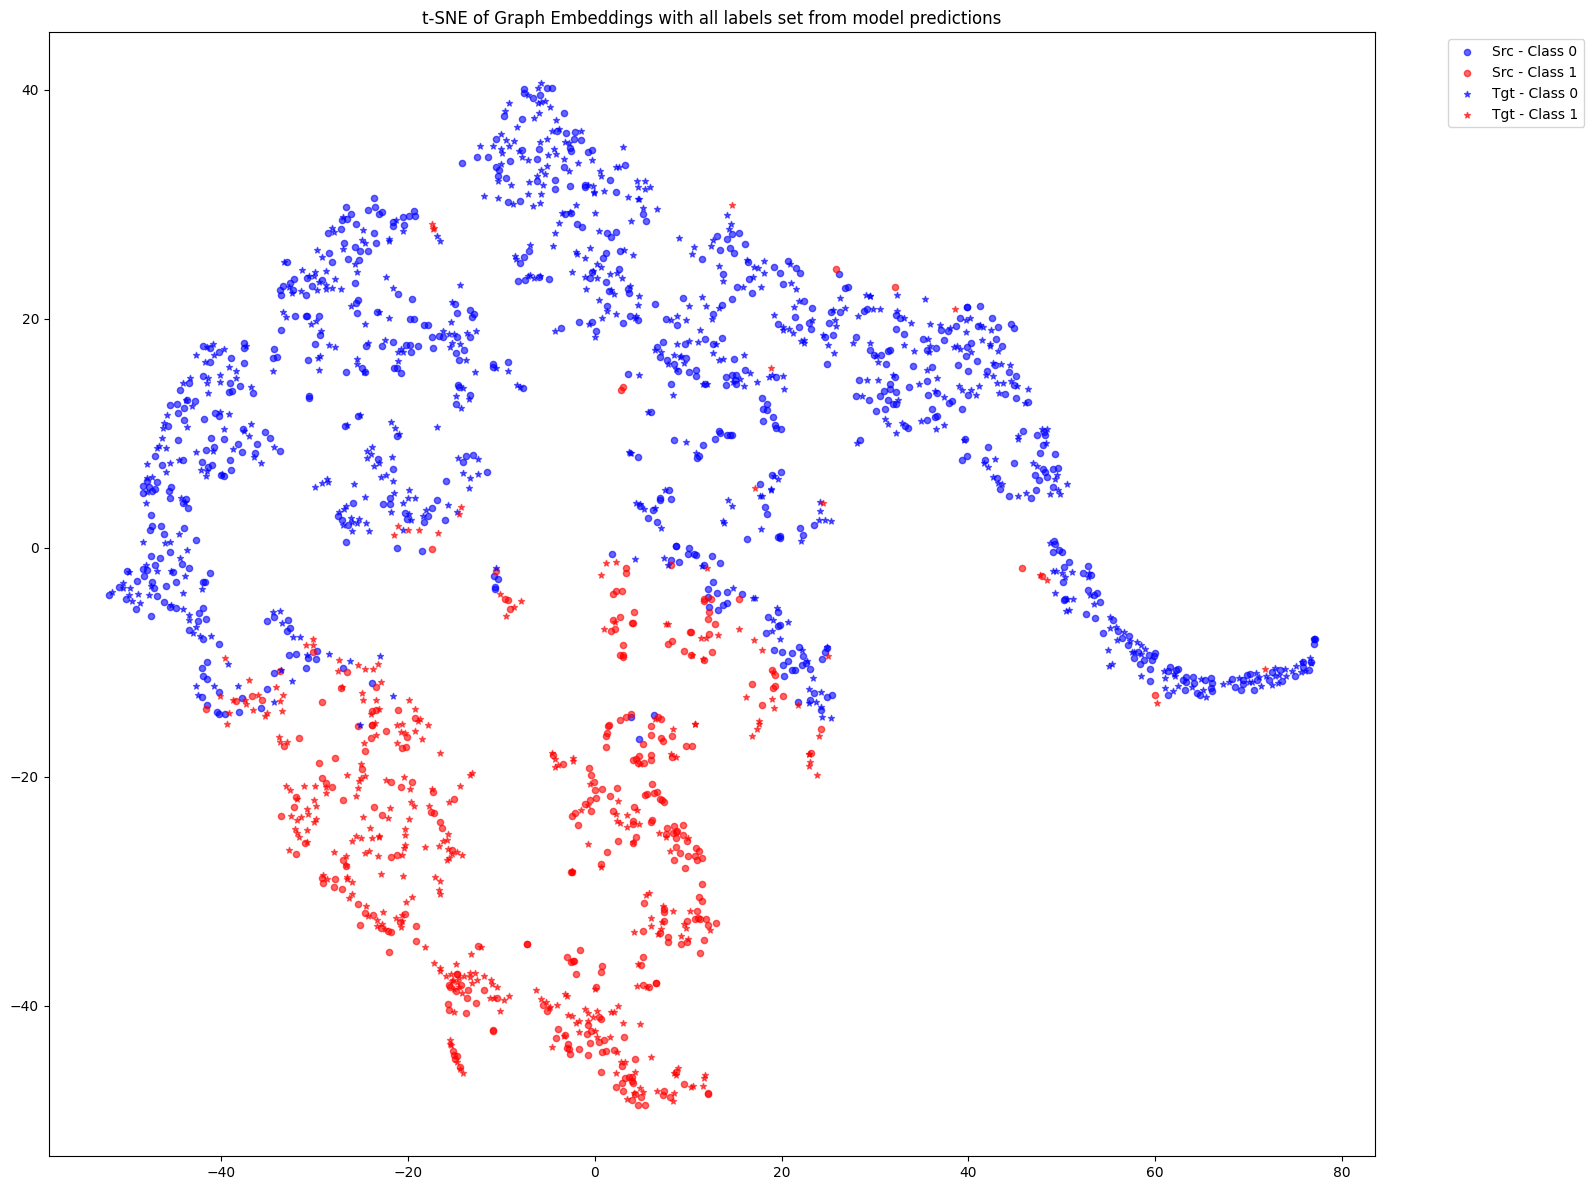

In [22]:
def collect_embeddings(encoder, clf, loader, device, domain_label):
    encoder.eval()
    clf.eval()
    all_embeds, all_labels, all_domains, all_preds = [], [], [], []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            x = encoder(data.x, data.edge_index, data.batch)
            logits = clf(x)
            preds = F.softmax(logits,dim=0).argmax(dim=1)
            all_embeds.append(x.cpu())
            all_labels.append(data.y.cpu())
            all_domains.append(torch.full((x.size(0),), domain_label))  # 0=source, 1=target
            all_preds.append(preds.cpu())

    return (
        torch.cat(all_embeds, dim=0),
        torch.cat(all_labels, dim=0),
        torch.cat(all_domains, dim=0),
        torch.cat(all_preds, dim=0)
    )

def plot_tsne(embeddings, labels, domains, title="t-SNE of Graph Embeddings"):
    tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)

    embeds_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(16, 12))
    for domain in [0, 1]:  # source vs target
        for label in torch.unique(labels):
            idx = (domains == domain) & (labels == label)
            plt.scatter(
                embeds_2d[idx, 0],
                embeds_2d[idx, 1],
                label=f"{'Src' if domain==0 else 'Tgt'} - Class {label.item()}",
                alpha=0.6,
                marker = 'o' if domain==0 else '*',
                color = 'b' if label.item()==0 else 'r',
                s=20
            )

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Assuming you have:
# - encoder (trained)
# - source_loader and target_loader
# - device (cuda or cpu)

src_embeds, src_labels, src_domains, src_preds = collect_embeddings(encoder, clf, src_loader_unweighted, device, domain_label=0)
tgt_embeds, tgt_labels, tgt_domains, tgt_preds = collect_embeddings(encoder, clf, tgt_loader, device, domain_label=1)

# Combine
all_embeds = torch.cat([src_embeds, tgt_embeds], dim=0)
all_labels = torch.cat([src_labels, tgt_labels], dim=0)
all_domains = torch.cat([src_domains, tgt_domains], dim=0)
all_preds = torch.cat([src_preds, tgt_preds], dim=0)
labels_and_preds = torch.cat([src_labels, tgt_preds], dim=0)

# Plot
plot_tsne(all_embeds.numpy(), all_labels, all_domains, title='t-SNE of Graph Embeddings with all target domain labels set to 0')
plot_tsne(all_embeds.numpy(), labels_and_preds, all_domains, title='t-SNE of Graph Embeddings with all target domain labels set from model predictions')
plot_tsne(all_embeds.numpy(), all_preds, all_domains, title='t-SNE of Graph Embeddings with all labels set from model predictions')



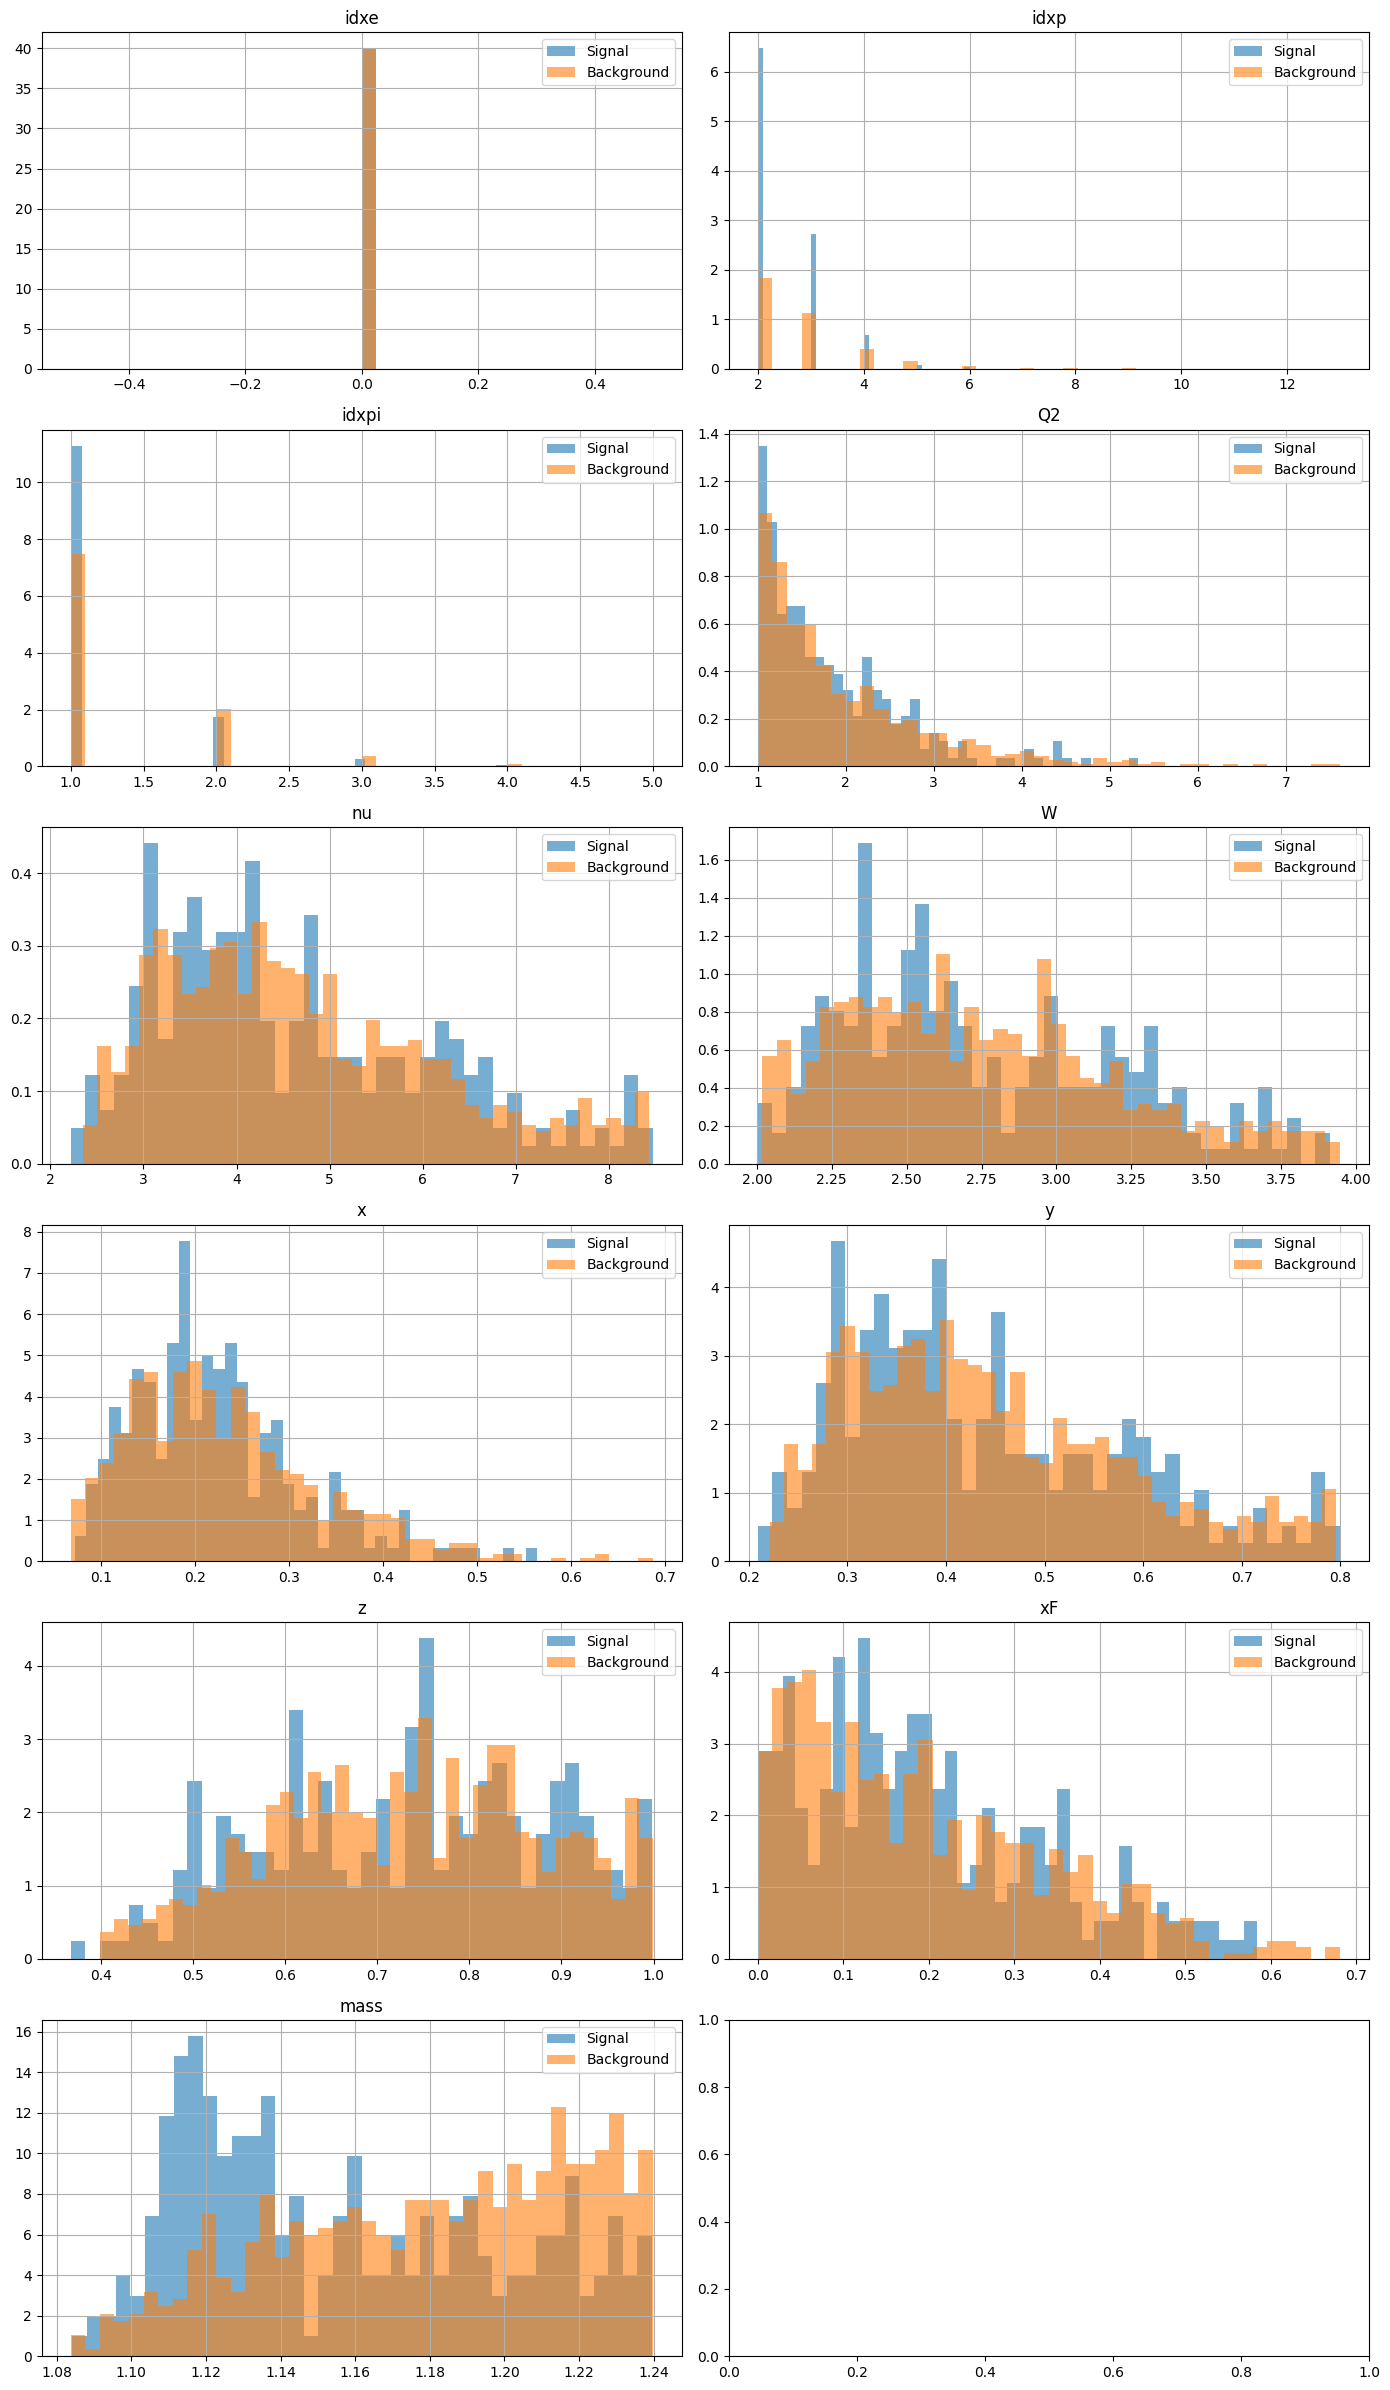

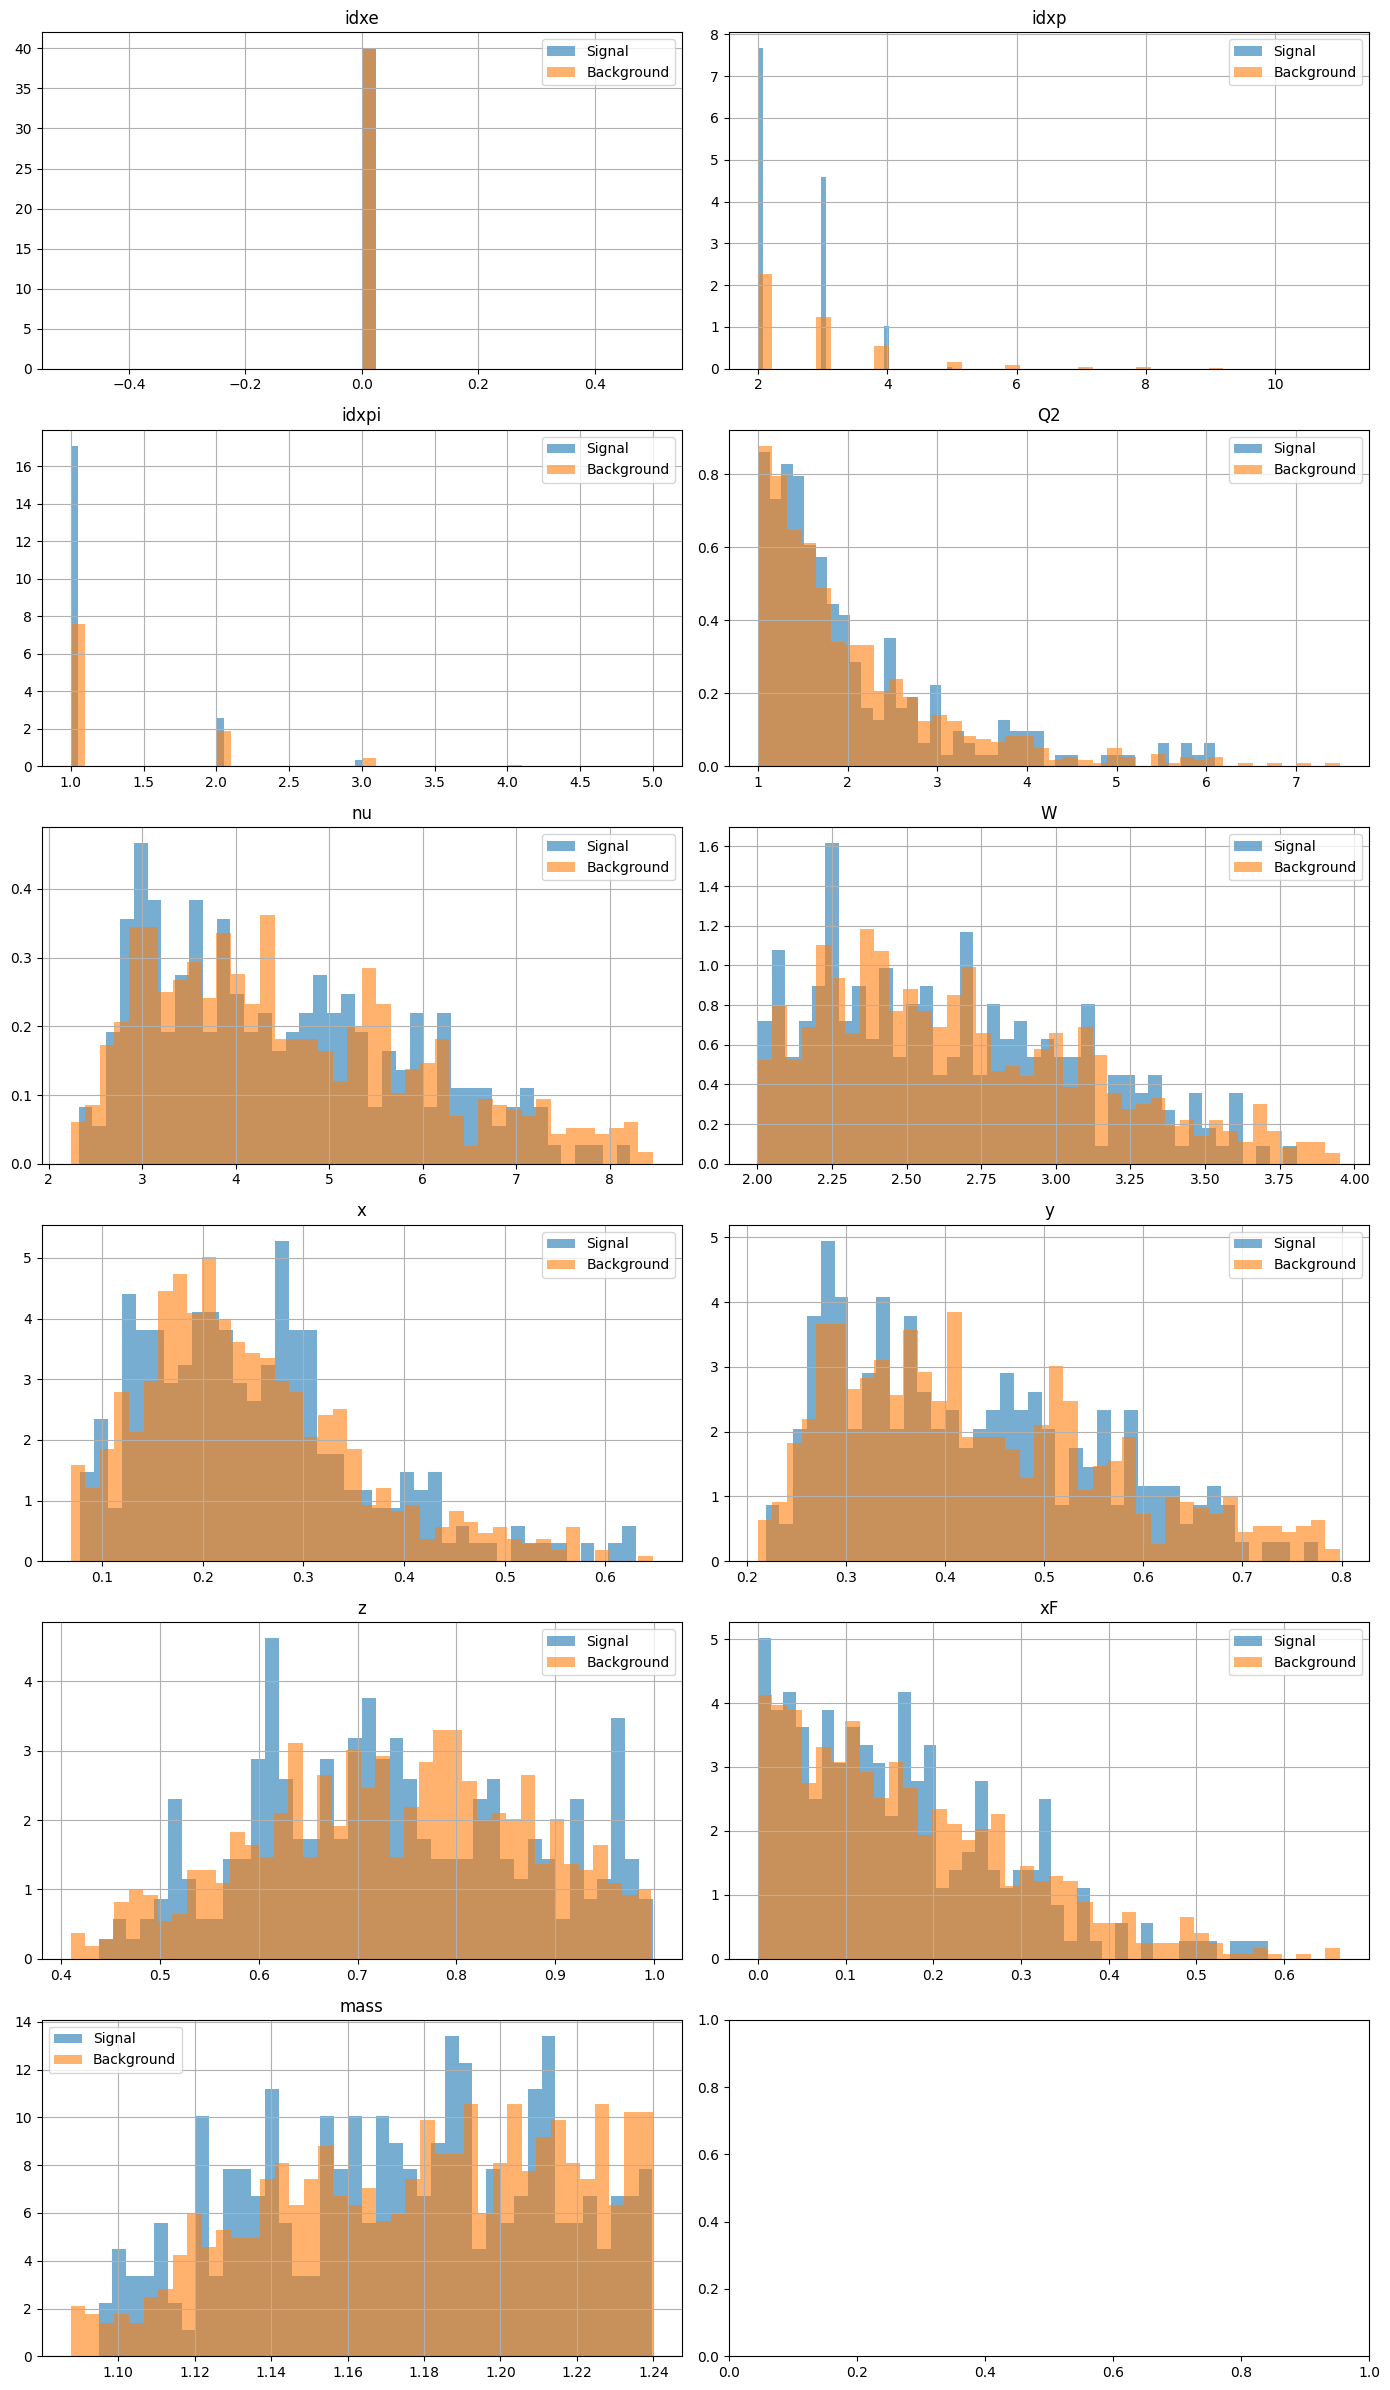

In [20]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def plot_kinematic_distributions(encoder, clf, dataloader, threshold=0.7, device='cuda',
                                  class_idx_signal=1, class_idx_background=0,
                                  kinematic_labels=None):
    """
    Plots histograms of each kinematic variable for predicted signal and background.
    """
    encoder.eval()
    clf.eval()
    all_kin_signal = []
    all_kin_bkg = []

    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            feats = encoder(data.x, data.edge_index, data.batch)
            logits = clf(feats)
            probs = F.softmax(logits, dim=1)
            pred_probs, pred_classes = probs.max(dim=1)

            # Apply threshold selection
            selected = pred_probs >= threshold
            selected_classes = pred_classes[selected]
            selected_kinematics = data.kinematics[selected]

            for k, cls in zip(selected_kinematics, selected_classes):
                if cls.item() == class_idx_signal:
                    all_kin_signal.append(k.cpu())
                elif cls.item() == class_idx_background:
                    all_kin_bkg.append(k.cpu())

    if not all_kin_signal or not all_kin_bkg:
        print("Not enough events passed the threshold to plot.")
        return

    # Convert to tensors
    kin_signal = torch.stack(all_kin_signal)  # [N_signal, num_kin_vars]
    kin_bkg = torch.stack(all_kin_bkg)        # [N_bkg, num_kin_vars]
    num_kin_vars = kin_signal.size(1)

    # Labels for plots
    if kinematic_labels is None:
        kinematic_labels = [f"Kin_{i}" for i in range(num_kin_vars)]

    # Plot
    fig, axs = plt.subplots(nrows=(num_kin_vars + 1) // 2, ncols=2, figsize=(14, 4 * ((num_kin_vars + 1) // 2)))
    axs = axs.flatten()

    for i in range(num_kin_vars):
        axs[i].hist(kin_signal[:, i], bins=40, alpha=0.6, label='Signal', color='C0', density=True)
        axs[i].hist(kin_bkg[:, i], bins=40, alpha=0.6, label='Background', color='C1', density=True)
        axs[i].set_title(kinematic_labels[i])
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

kinematic_labels = ['idxe', 'idxp', 'idxpi', 'Q2', 'nu', 'W', 'x', 'y', 'z', 'xF', 'mass']
plot_kinematic_distributions(encoder, clf, src_loader_unweighted, threshold=best_thr, device='cuda',
                                  class_idx_signal=1, class_idx_background=0,
                                  kinematic_labels=kinematic_labels)

plot_kinematic_distributions(encoder, clf, tgt_loader, threshold=best_thr, device='cuda',
                                  class_idx_signal=1, class_idx_background=0,
                                  kinematic_labels=kinematic_labels)

In [19]:
src_ds[1].kinematics

tensor([[0.0000, 2.0000, 1.0000, 1.8310, 3.8361, 2.4997, 0.2543, 0.3619, 0.6718,
         0.1926, 1.1227]])

In [1]:
import numpy as np
print("HERE")

HERE


In [6]:
len(src_loader.dataset)

556

In [16]:
help(src_loader)

Help on DataLoader in module torch_geometric.loader.dataloader object:

class DataLoader(torch.utils.data.dataloader.DataLoader)
 |  DataLoader(dataset: Union[torch_geometric.data.dataset.Dataset, Sequence[torch_geometric.data.data.BaseData], torch_geometric.data.datapipes.DatasetAdapter], batch_size: int = 1, shuffle: bool = False, follow_batch: Optional[List[str]] = None, exclude_keys: Optional[List[str]] = None, **kwargs)
 |  
 |  A data loader which merges data objects from a
 |  :class:`torch_geometric.data.Dataset` to a mini-batch.
 |  Data objects can be either of type :class:`~torch_geometric.data.Data` or
 |  :class:`~torch_geometric.data.HeteroData`.
 |  
 |  Args:
 |      dataset (Dataset): The dataset from which to load the data.
 |      batch_size (int, optional): How many samples per batch to load.
 |          (default: :obj:`1`)
 |      shuffle (bool, optional): If set to :obj:`True`, the data will be
 |          reshuffled at every epoch. (default: :obj:`False`)
 |     